#  <p style="text-align: center;">COMPUTER VISION: IMAGE CLASSIFICATION - CONVOLUTIONAL NEURAL NETWORK [CNNs]

**Objective:** Develop a Convolutional Neural Network From Scratch for MNIST Handwritten Digit Classification.

**Context:** Develop a deep learning model to achieve near state of the art performance on the MNIST handwritten digit recognition task in Python using the Keras deep learning library.

###  Load the Libraries:

In [1]:
# Numerical and data libraries
import pandas as pd
import numpy as np

# Initialize the random number generator
import random
random.seed(0)

# Utilities for confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

# Ignore the warnings
import warnings
warnings.filterwarnings("ignore")

import tensorflow
import tensorflow.keras

# importing ploting libraries
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.signal import convolve2d
import cv2

import time
from tensorflow.keras.utils import to_categorical  
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras import utils as np_utils
from tensorflow.keras import metrics

### Load MNIST Dataset:

In [2]:
from tensorflow.keras.datasets import mnist
(train_X,train_Y), (test_X,test_Y) = mnist.load_data()

_, img_rows, img_cols =  train_X.shape
num_classes = len(np.unique(train_Y))
num_input_nodes = img_rows*img_cols

print("Number of training samples: %d"%train_X.shape[0])
print("Number of test samples: %d"%test_X.shape[0])
print("Image rows: %d"%train_X.shape[1])
print("Image columns: %d"%train_X.shape[2])
print("Number of classes: %d"%num_classes)

Number of training samples: 60000
Number of test samples: 10000
Image rows: 28
Image columns: 28
Number of classes: 10


### Visualize data before pre-processing: Example from each output class

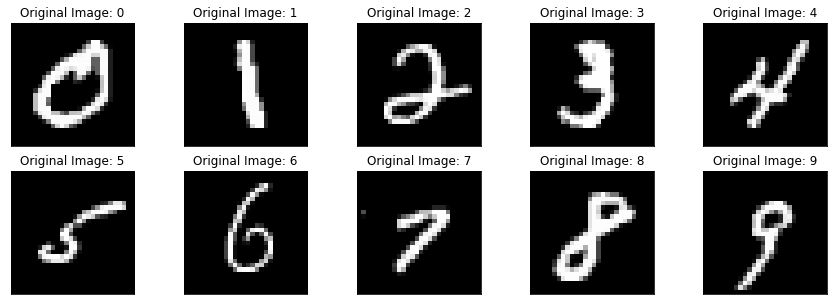

In [3]:
fig = plt.figure(figsize=(15,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    image = train_X[train_Y[:]==i,:]
    ax.set_title("Original Image: " + str(i))
    plt.imshow(image[1], cmap="gray")
plt.show()

The MNIST digits dataset is a dataset of 60,000 training and 10,000 test, small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

### DATA PRE-PROCESSING:

Normalize the data

In [4]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X /= 255
test_X /= 255

### Applying the Gaussian Blur to an indeprendant dataset

 Create duplicate datasets to visualise before and after effects of Data-Preprocessing for Gaussian Blur:

In [5]:
train_X_blur = train_X
test_X_blur = test_X

Now we create an empty numpy array, which will be used to store the new values after applying Gaussian Blurring filter to the original image data set:

In [6]:
train_X_blurred = np.empty((60000, 28, 28))
test_X_blurred = np.empty((10000, 28, 28))

In the following step, we iterate through each row, and convert the 1-D array of (60 000 training, 10 000 test) image data to an array of 28x28 pixels 2-D array.

In [7]:
for idx, line in enumerate(train_X_blur):
  train_X_blurred[idx] = line.reshape((28, 28))

for idx, line in enumerate(test_X_blur):
  test_X_blurred[idx] = line.reshape((28, 28))

Now we apply the gaussian blur to each 28x28 pixels array (image) to reduce the noise in the image

In [8]:
for idx, line in enumerate(train_X_blur):
  train_X_blurred[idx] = cv2.GaussianBlur(line, (5, 5), 0)

for idx, line in enumerate(test_X_blur):
  test_X_blurred[idx] = cv2.GaussianBlur(line, (5, 5), 0)

### Visualize data before and after Guassian Blurring pre-processing:

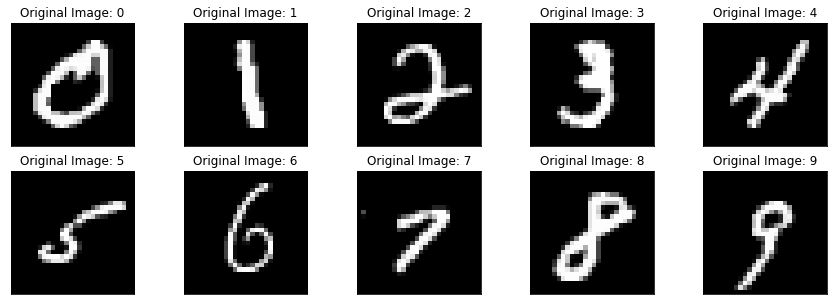

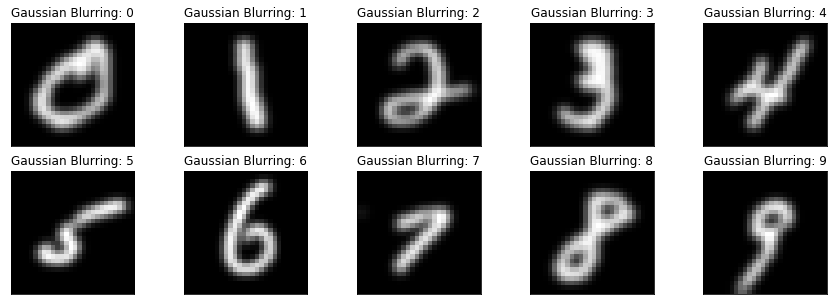

In [9]:
fig = plt.figure(figsize=(15,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    image = train_X[train_Y[:]==i,:]
    ax.set_title("Original Image: " + str(i))
    plt.imshow(image[1], cmap="gray")
plt.show()

fig = plt.figure(figsize=(15,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    image = train_X_blurred[train_Y[:]==i,:]
    ax.set_title("Gaussian Blurring: " + str(i))
    plt.imshow(image[1], cmap="gray")
plt.show()

### Visualize data after pre-processing (without Gaussian Blurring):

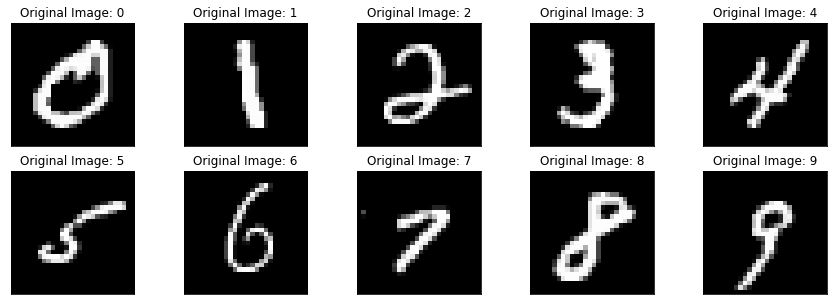

In [10]:
fig = plt.figure(figsize=(15,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    image = train_X[train_Y[:]==i,:]
    ax.set_title("Original Image: " + str(i))
    plt.imshow(image[1], cmap="gray")
plt.show()

### Reshape data into shapes compatible with Keras models:

 Reshape train and test sets (not Gaussian Blurred) into compatible shapes

In [11]:
train_X = train_X.reshape(train_X.shape[0], 28, 28, 1)
test_X = test_X.reshape(test_X.shape[0], 28, 28, 1)

 Reshape train and test sets (Gaussian Blurred) into compatible shapes

In [12]:
train_X_blurred = train_X_blurred.reshape(train_X_blur.shape[0], 28, 28, 1)
test_X_blurred = test_X_blurred.reshape(test_X_blur.shape[0], 28, 28, 1)

### Convert labels from digits to one hot vectors

In [13]:
# convert class labels to binary class labels
train_Y = np_utils.to_categorical(train_Y, num_classes)
test_Y = np_utils.to_categorical(test_Y, num_classes)

### Print the label for y_train[0]

In [14]:
print("Shape of y_train:", train_Y.shape)
print("One value of y_train:", train_Y[0])

Shape of y_train: (60000, 10)
One value of y_train: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Function to plot model accuracy and loss:

In [15]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

### Funtion to compute test accuracy:

In [16]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

### A SIMPLE CONVOLUTIONAL NEURAL NETWORK [CNN]

**Initialize a sequential model again:**
- define a sequential model
- add a convolutional layers
    - no of filters: 32
    - kernel size: 3x3
    - activation: "relu"
    - input shape: (28, 28, 1) for first layer
- flatten the data
    - add Flatten later
    - flatten layers flatten 2D arrays to 1D array before building the fully connected layers
- add a dense layer;
    - number of neurons in the dense layer: number of classes [10]
    - activation function in last layer: softmax

In [17]:
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model.add(Flatten())
model.add(Dense(10, activation="softmax"))

### Compile and fit the model
- let's compile our model
    - loss: "categorical_crossentropy"
    - metrics: "accuracy"
    - optimizer: "adam"
- then next step will be to fit model
    - batch size: 32
    - epochs: 10

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 22s 532us/sample - loss: 0.2139 - accuracy: 0.9389 - val_loss: 0.1079 - val_accuracy: 0.9683
Epoch 2/10
42000/42000 [==============================] - 23s 556us/sample - loss: 0.0736 - accuracy: 0.9785 - val_loss: 0.0871 - val_accuracy: 0.9742
Epoch 3/10
42000/42000 [==============================] - 23s 544us/sample - loss: 0.0488 - accuracy: 0.9859 - val_loss: 0.0796 - val_accuracy: 0.9778
Epoch 4/10
42000/42000 [==============================] - 25s 607us/sample - loss: 0.0374 - accuracy: 0.9882 - val_loss: 0.0825 - val_accuracy: 0.9775
Epoch 5/10
42000/42000 [==============================] - 23s 547us/sample - loss: 0.0275 - accuracy: 0.9918 - val_loss: 0.0849 - val_accuracy: 0.9763
Epoch 6/10
42000/42000 [==============================] - 23s 537us/sample - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0878 - val_accuracy: 0.9771
Epoch 7/10
42000/42000 [====================

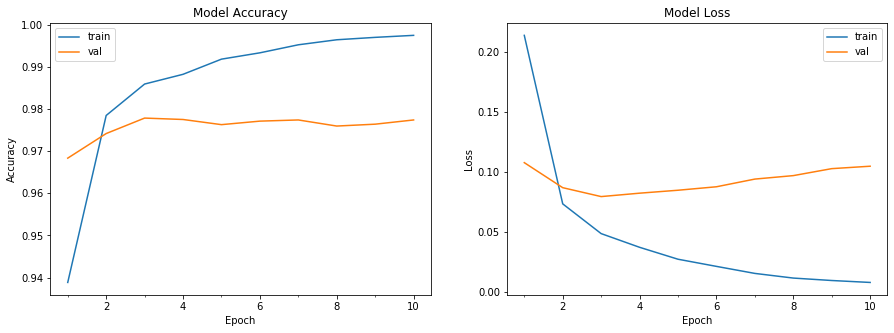

Model took 232.15 seconds to train
Accuracy on test data is: 97.96


In [18]:
# Compile the model
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
start = time.time()
model_info = model.fit( x=train_X, y=train_Y, batch_size=32, epochs=10, validation_split = 0.3)

end = time.time()
# plot model history
plot_model_history(model_info)
print("Model took %0.2f seconds to train"%(end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%accuracy(test_X, test_Y, model))

**Summary of the model:**

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


### Increase network depth by adding multiple layers

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 93s 2ms/sample - loss: 0.1476 - accuracy: 0.9554 - val_loss: 0.0674 - val_accuracy: 0.9796
Epoch 2/10
42000/42000 [==============================] - 96s 2ms/sample - loss: 0.0461 - accuracy: 0.9856 - val_loss: 0.0561 - val_accuracy: 0.9840
Epoch 3/10
42000/42000 [==============================] - 89s 2ms/sample - loss: 0.0296 - accuracy: 0.9902 - val_loss: 0.0497 - val_accuracy: 0.9861
Epoch 4/10
42000/42000 [==============================] - 88s 2ms/sample - loss: 0.0180 - accuracy: 0.9941 - val_loss: 0.0569 - val_accuracy: 0.9853
Epoch 5/10
42000/42000 [==============================] - 87s 2ms/sample - loss: 0.0147 - accuracy: 0.9950 - val_loss: 0.0573 - val_accuracy: 0.9868
Epoch 6/10
42000/42000 [==============================] - 92s 2ms/sample - loss: 0.0124 - accuracy: 0.9955 - val_loss: 0.0532 - val_accuracy: 0.9866
Epoch 7/10
42000/42000 [==============================] 

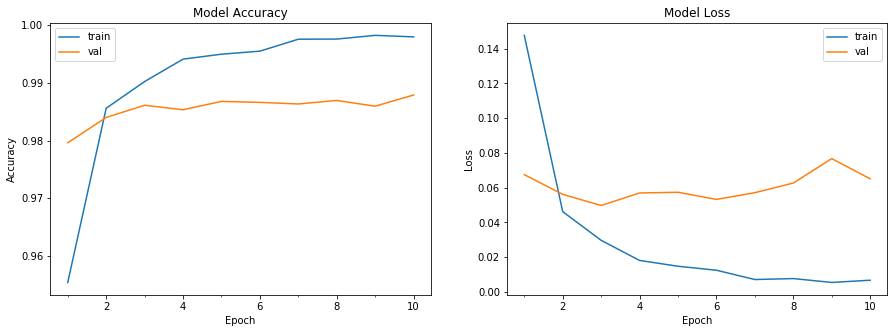

Model took 904.92 seconds to train
Accuracy on test data is: 98.90


In [20]:
model2 = Sequential()
model2.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model2.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model2.add(MaxPooling2D(pool_size=(2,2)))
model2.add(Flatten())
model2.add(Dense(128, activation="relu"))
model2.add(Dense(10, activation="softmax"))

# Compile the model
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
start = time.time()
model_info2 = model2.fit( x=train_X, y=train_Y, batch_size=32, epochs=10, validation_split = 0.3)

end = time.time()
# plot model history
plot_model_history(model_info2)
print("Model took %0.2f seconds to train"%(end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%accuracy(test_X, test_Y, model2))

**Summary of the model:**

In [21]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1290      
Total params: 600,810
Trainable params: 600,810
Non-trainable params: 0
________________________________________________

**Observation:**
Increasing network depth, increased the test accuracy but also increased the training time.

### Try fitting Gaussian Blurring data to the Convolutional Neural Network [CNN]

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 87s 2ms/sample - loss: 0.1735 - accuracy: 0.9474 - val_loss: 0.0856 - val_accuracy: 0.9739
Epoch 2/10
42000/42000 [==============================] - 88s 2ms/sample - loss: 0.0599 - accuracy: 0.9821 - val_loss: 0.0693 - val_accuracy: 0.9794
Epoch 3/10
42000/42000 [==============================] - 72s 2ms/sample - loss: 0.0387 - accuracy: 0.9881 - val_loss: 0.0678 - val_accuracy: 0.9805
Epoch 4/10
42000/42000 [==============================] - 67s 2ms/sample - loss: 0.0299 - accuracy: 0.9904 - val_loss: 0.0543 - val_accuracy: 0.9843
Epoch 5/10
42000/42000 [==============================] - 68s 2ms/sample - loss: 0.0227 - accuracy: 0.9927 - val_loss: 0.0602 - val_accuracy: 0.9838
Epoch 6/10
42000/42000 [==============================] - 67s 2ms/sample - loss: 0.0187 - accuracy: 0.9938 - val_loss: 0.0648 - val_accuracy: 0.9826
Epoch 7/10
42000/42000 [==============================] 

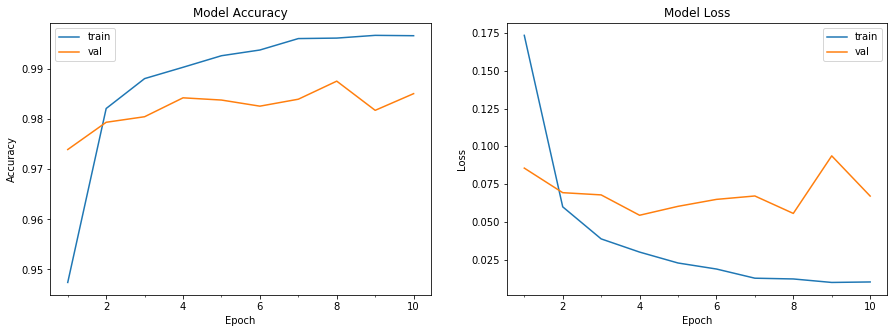

Model took 720.86 seconds to train
Accuracy on test data is: 98.61


In [22]:
model_blur = Sequential()
model_blur.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model_blur.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model_blur.add(MaxPooling2D(pool_size=(2,2)))
model_blur.add(Flatten())
model_blur.add(Dense(128, activation="relu"))
model_blur.add(Dense(10, activation="softmax"))

# Compile the model
model_blur.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
start = time.time()
model_blur_info = model_blur.fit(x=train_X_blurred, y=train_Y, batch_size=32, epochs=10, validation_split = 0.3)

end = time.time()
# plot model history
plot_model_history(model_blur_info)
print("Model took %0.2f seconds to train"%(end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%accuracy(test_X_blurred, test_Y, model_blur))

**Summary of the model:**

In [23]:
model_blur.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               589952    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
Total params: 600,810
Trainable params: 600,810
Non-trainable params: 0
________________________________________________

**Observation:**
Note there is minimal improvement in accuracy after using gaussian blurring.

### Add Droput Layer to the Convolutional Neural Network [CNN]

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 70s 2ms/sample - loss: 0.2331 - accuracy: 0.9292 - val_loss: 0.0683 - val_accuracy: 0.9799
Epoch 2/10
42000/42000 [==============================] - 68s 2ms/sample - loss: 0.0901 - accuracy: 0.9731 - val_loss: 0.0544 - val_accuracy: 0.9847
Epoch 3/10
42000/42000 [==============================] - 68s 2ms/sample - loss: 0.0646 - accuracy: 0.9804 - val_loss: 0.0542 - val_accuracy: 0.9846
Epoch 4/10
42000/42000 [==============================] - 68s 2ms/sample - loss: 0.0532 - accuracy: 0.9834 - val_loss: 0.0468 - val_accuracy: 0.9862
Epoch 5/10
42000/42000 [==============================] - 69s 2ms/sample - loss: 0.0457 - accuracy: 0.9852 - val_loss: 0.0536 - val_accuracy: 0.9858
Epoch 6/10
42000/42000 [==============================] - 68s 2ms/sample - loss: 0.0387 - accuracy: 0.9875 - val_loss: 0.0465 - val_accuracy: 0.9872
Epoch 7/10
42000/42000 [==============================] 

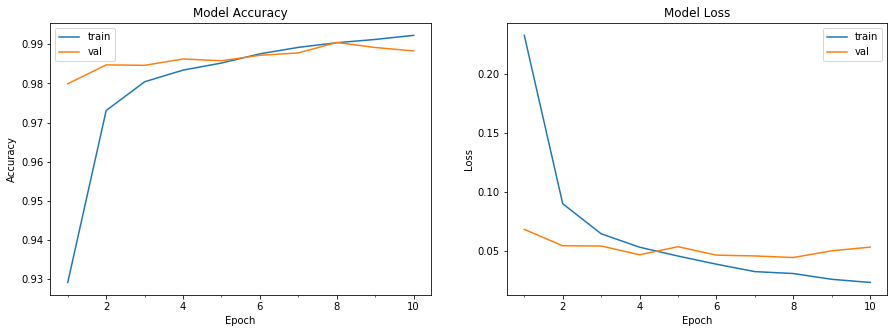

Model took 685.13 seconds to train
Accuracy on test data is: 98.99


In [24]:
model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model3.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model3.add(MaxPooling2D(pool_size=(2,2)))
model3.add(Flatten())
model3.add(Dense(128, activation="relu"))
model3.add(Dropout(0.5))
model3.add(Dense(10, activation="softmax"))

# Compile the model
model3.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
start = time.time()
model_info3 = model3.fit( x=train_X, y=train_Y, batch_size=32, epochs=10, validation_split = 0.3)

end = time.time()
# plot model history
plot_model_history(model_info3)
print("Model took %0.2f seconds to train"%(end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%accuracy(test_X, test_Y, model3))

**Summary of the model:**

In [25]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

**Observation:**
Adding the droput layer increases the test accuracy while increasing the training time. Dropout layer adds regularization to the network by preventing weights to converge at the same position. During forward propagation, nodes are turned off randomly while all nodes are turned on during forward propagartion.

### Add Batch Normalization to the Convolutional Neural Network [CNN]

Adding the batch normalization will normalizes the network input weights between 0 and 1. This allows using higher learning rates when using SGD and for some datasets, and eliminates the need for dropout layer.

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 70s 2ms/sample - loss: 0.1253 - accuracy: 0.9632 - val_loss: 0.0591 - val_accuracy: 0.9829
Epoch 2/10
42000/42000 [==============================] - 69s 2ms/sample - loss: 0.0471 - accuracy: 0.9861 - val_loss: 0.0493 - val_accuracy: 0.9853
Epoch 3/10
42000/42000 [==============================] - 69s 2ms/sample - loss: 0.0285 - accuracy: 0.9911 - val_loss: 0.0552 - val_accuracy: 0.9836
Epoch 4/10
42000/42000 [==============================] - 68s 2ms/sample - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.0563 - val_accuracy: 0.9840
Epoch 5/10
42000/42000 [==============================] - 69s 2ms/sample - loss: 0.0157 - accuracy: 0.9946 - val_loss: 0.0638 - val_accuracy: 0.9824
Epoch 6/10
42000/42000 [==============================] - 70s 2ms/sample - loss: 0.0140 - accuracy: 0.9953 - val_loss: 0.0581 - val_accuracy: 0.9848
Epoch 7/10
42000/42000 [==============================] 

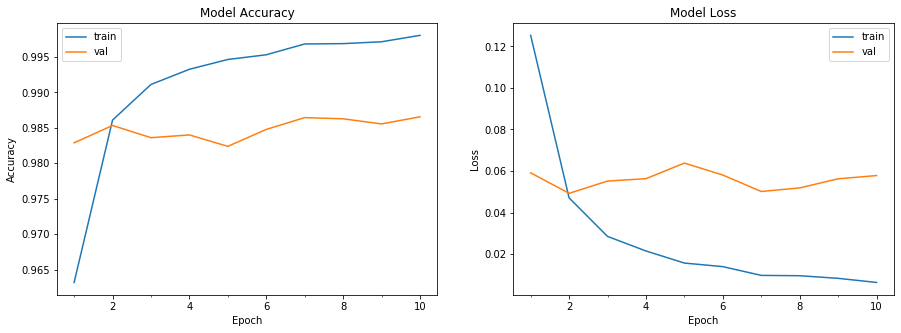

Model took 690.49 seconds to train
Accuracy on test data is: 98.58


In [26]:
model4 = Sequential()
model4.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(28, 28, 1)))
model4.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model4.add(MaxPooling2D(pool_size=(2,2)))
model4.add(Flatten())
model4.add(Dense(128, activation="relu"))
model4.add(BatchNormalization())
model4.add(BatchNormalization())
model4.add(Dense(10, activation="softmax"))

# Compile the model
model4.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

# Fit the model
start = time.time()
model_info4 = model4.fit( x=train_X, y=train_Y, batch_size=32, epochs=10, validation_split = 0.3)

end = time.time()
# plot model history
plot_model_history(model_info4)
print("Model took %0.2f seconds to train"%(end - start))
# compute test accuracy
print("Accuracy on test data is: %0.2f"%accuracy(test_X, test_Y, model4))

**Summary of the model:**

In [27]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               589952    
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)              

**Observation:** Adding the batch normalization increases the test accuracy while increasing the training time.

### VISUALIZE PREDICTIONS [OF MOST ACCURATE MODEL] - CNN MODEL 3 [CNN WITH DROPOUT LAYER]

In [28]:
y_predict = model3.predict(test_X)

**Visualize predictions for:** x_test[2], x_test[3], x_test[33], x_test[36], x_test[59] 

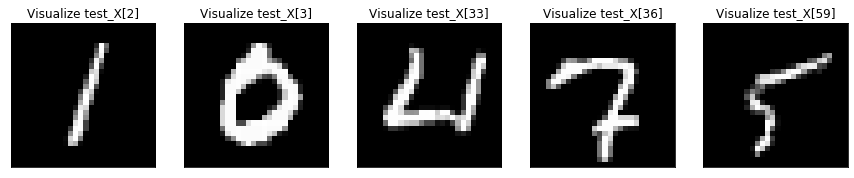

Visualize predictions for test_X[2]: 1.00
Visualize predictions for test_X[3]: 0.00
Visualize predictions for test_X[33]: 4.00
Visualize predictions for test_X[36]: 7.00
Visualize predictions for test_X[59]: 5.00


In [29]:
visual = {1:2, 2:3, 3:33, 4:36, 5:59}

fig = plt.figure(figsize=(15,10))
for i in visual:
    ax = fig.add_subplot(1, 5, i, xticks=[], yticks=[])
    ax.set_title("Visualize test_X[" + str(visual[i]) + "]")
    image = test_X[visual[i]].reshape(1,28,28,1)
    plt.imshow(image[0,:,:,0],cmap="gray")
plt.show()

print("Visualize predictions for test_X[2]: %0.2f"%np.argmax(y_predict[2]))
print("Visualize predictions for test_X[3]: %0.2f"%np.argmax(y_predict[3]))
print("Visualize predictions for test_X[33]: %0.2f"%np.argmax(y_predict[33]))
print("Visualize predictions for test_X[36]: %0.2f"%np.argmax(y_predict[36]))
print("Visualize predictions for test_X[59]: %0.2f"%np.argmax(y_predict[59]))

**Visualise all model predictions:**

In [30]:
y_pred = []
for val in y_predict:
    y_pred.append(np.argmax(val))
print(y_pred)    

[7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 3, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 7, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 

#### END OF CONVOLUTIONAL NEURAL NETWORK [CNN] PROJECT - DIGIT CLASSIFICATION PREDICTION!